In [11]:
import numpy as np
import emcee
import matplotlib.pyplot as plt
# from multiprocessing import Pool

%matplotlib widget

# Generate synthetic data


In [12]:
np.random.seed(42)
true_amplitude = 2.5
true_frequency = 1.0
true_phase = 0.5
true_offset = 0.1
# x = np.linspace(0, 10, 50) #this doesn't converge very well...
x = np.random.uniform(0,10,50)
y = true_amplitude * np.sin(true_frequency * x + true_phase) + true_offset
y += 0.5 * np.random.randn(len(x))  # Add some noise

# Define the Sine Function and Log-Likelihood Function

In [13]:
def model(params, x):
    amplitude, frequency, phase, offset = params
    return amplitude * np.sin(frequency * x + phase) + offset

def log_likelihood(params, x, y):
    model_y = model(params, x)
    sigma2 = 0.25  # Assume some noise level
    return -0.5 * np.sum((y - model_y) ** 2 / sigma2 + np.log(sigma2))

def log_prior(params):
    amplitude, frequency, phase, offset = params
    if 0 < amplitude < 10 and 0 < frequency < 10 and -2 * np.pi < phase < 2 * np.pi and -10 < offset < 10:
        return 0.0
    return -np.inf

def log_probability(params, x, y):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, x, y)


# Set up the MCMC sampler

In [14]:
# Initial guesses for parameters
initial = np.array([1.0, 1.0, 0.0, 0.0])
nwalkers = 32
ndim = len(initial)
pos = initial + 1e-4 * np.random.randn(nwalkers, ndim)

# Set up the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y))


# Run MCMC

In [15]:
# Run the MCMC sampler
nsteps = 5000
sampler.run_mcmc(pos, nsteps, progress=True)

# Discard burn-in samples and flatten the chain
burn_in = 1000
samples = sampler.get_chain(discard=burn_in, flat=True)


100%|██████████| 5000/5000 [00:06<00:00, 761.06it/s]


In [9]:
# # Parallelization setup
# with Pool() as pool:
#     sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y), pool=pool)
    
#     # Run the MCMC sampler
#     nsteps = 5000
#     sampler.run_mcmc(pos, nsteps, progress=True)

# # Discard burn-in samples and flatten the chain
# burn_in = 1000
# samples = sampler.get_chain(discard=burn_in, flat=True)

# Check 

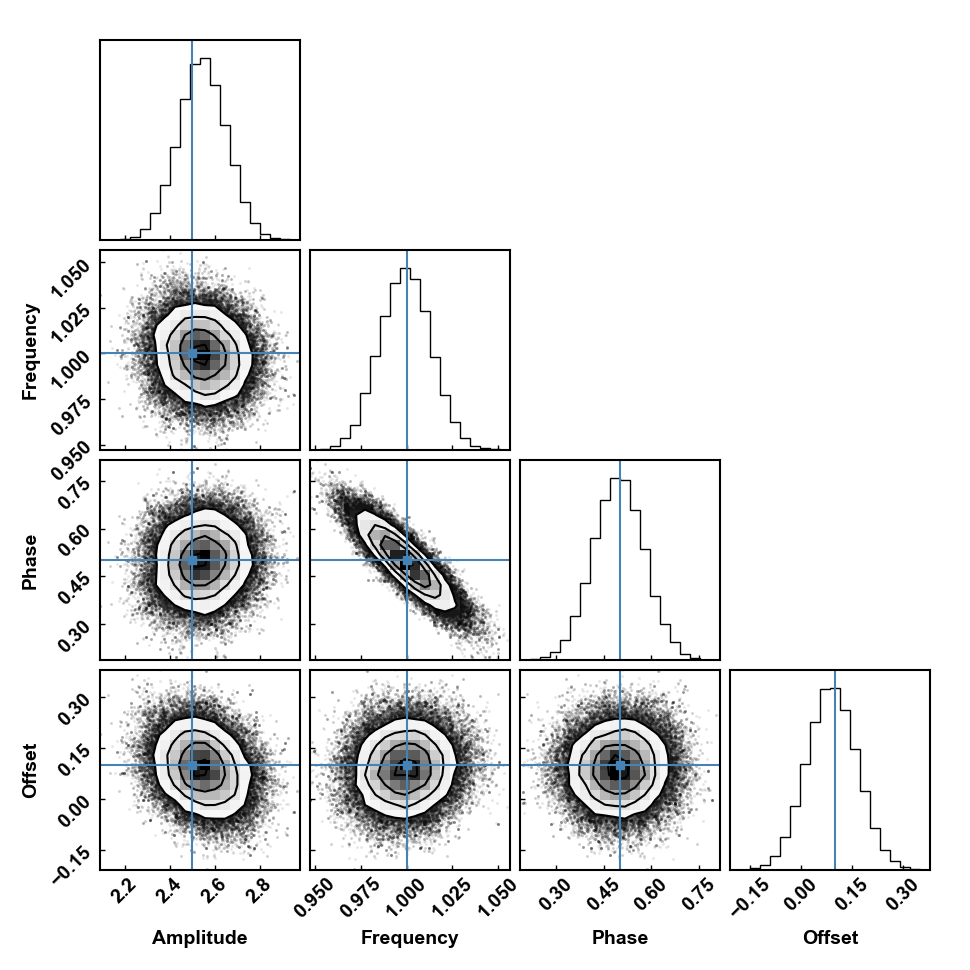

Best-fit parameters: [2.54440366 0.99930014 0.4971267  0.09000817]


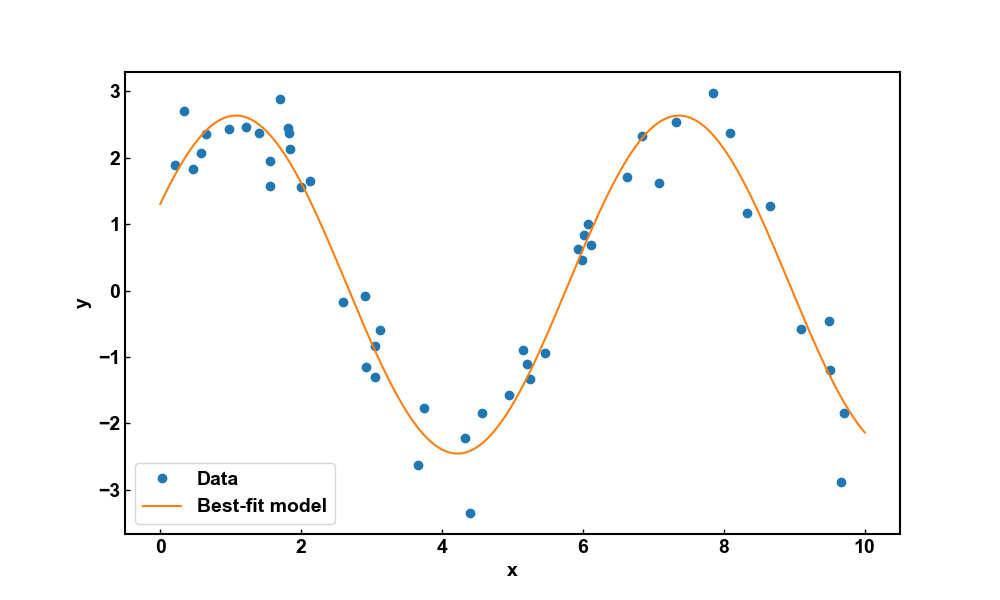

In [16]:
import corner

# Plot the corner plot
fig = corner.corner(samples, labels=["Amplitude", "Frequency", "Phase", "Offset"], truths=[true_amplitude, true_frequency, true_phase, true_offset])
plt.show()

# Extract the best-fit parameters
best_fit_params = np.median(samples, axis=0)
print("Best-fit parameters:", best_fit_params)

# Plot the data and the best-fit model
plt.figure(figsize=(10, 6))
plt.plot(x, y, 'o', label="Data")
x_fit = np.linspace(0, 10, 1000)
y_fit = model(best_fit_params, x_fit)
plt.plot(x_fit, y_fit, label="Best-fit model")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()
